# Finding Facebook relationships within EPFL student lists

Proof of concept

## TL;DR

We wanted to see if, from EPFL student lists such as the ones gathered for the ADA class homework, we could obtain the graph of these students' Facebook relationships with one another.

As the latest Facebook API doesn't allow retrieving friends lists, we built a Selenium bot capable of scraping them. The information gathered is limited by user settings (people can keep their friends list private) and Facebook's own anti-bot behavior.

Still, we got some results. Here we walk through an example taking a look at 2nd year bachelor students in Sciences du vivant. Finally, as an exercise, we test if the difference of average degree (in the graph) between men and women is significative.

_The final adjacency matrix:_

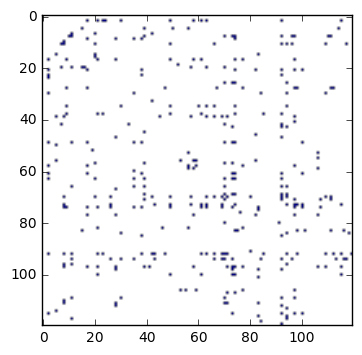

In [295]:
C = C.replace(0, np.nan)
fig, ax = plt.subplots()
ax.imshow(C)
plt.show()

_The graph obtained on gephi, (stereotypically) colored by gender:_

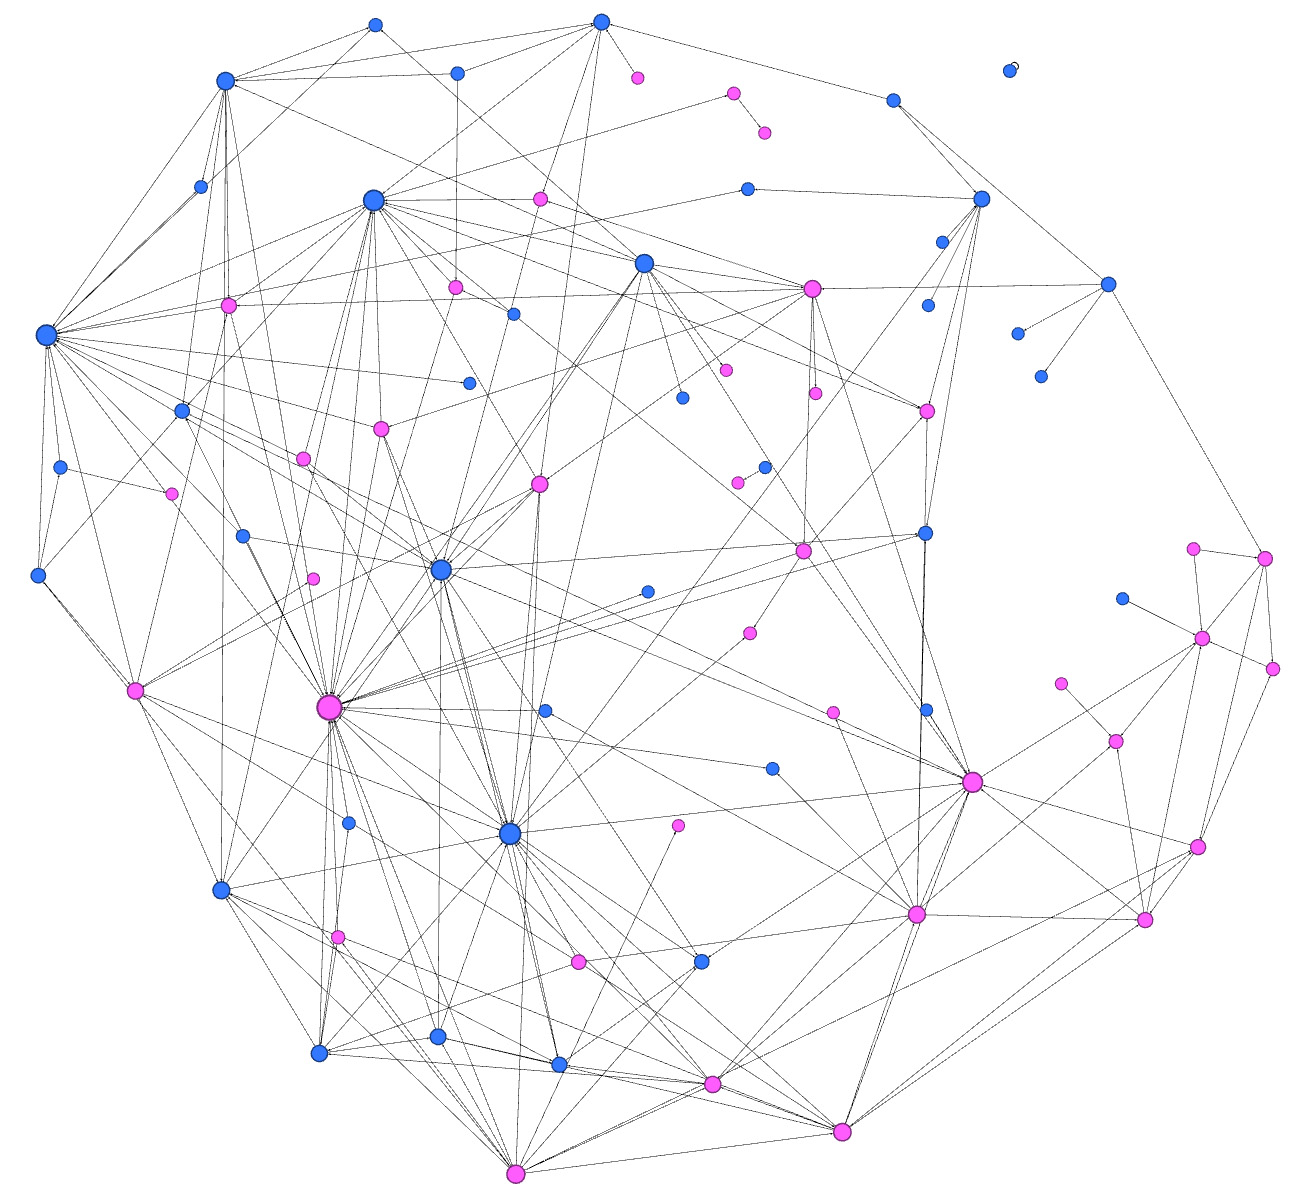

In [296]:
Image(filename='graph.jpg')

## The recipe

We import required modules

In [316]:
from IPython.display import Image

# BSoup imports
import urllib.request
from bs4 import BeautifulSoup as BSoup

# Selenium imports
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException

# Pandas imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Support
import time, random, unicodedata, os
import scipy.stats as stats

We will try to build the graph of second year SV students

## Finding useful names

The names that are provided on the IS-Academia lists are in fact _all_ the names a person has. If we want to have a chance to find this person on Facebook, we need to know which of these names they actually use.

The idea is to search for each person on epfl.people.ch and get their email address, which we assume contains only the names the person goes by on FB.

### Preparation

Some string functions we will need:

In [61]:
def switchNames(name):
    """ returns re-ordered name firstname-surname """
    n = name.find(u'\xa0')
    nom = name[:n]
    prenom = name[n+1:]
    return prenom+' '+nom

def plusName(name):
    """ replaces spaces in a string with + """
    return name.replace(' ', '+')

def mailToName(email):
    """ takes an email as formatted by epfl.people and returns name surname """
    email = email[email.find("'")+1:]
    name = email[0:email.find("'")]
    return name.replace('.', ' ')

def spaceCounter(s):
    return s.count(' ')

def sepNames(l, s):
    # normalize the name
    l = unicodedata.normalize('NFKD', l).encode('ascii','ignore').decode('utf-8')
    # splitting it in subnames
    l = l.lower().split(' ')
    for i in l:
        print(i, s.find(i))
        if s.find(i) != -1:
            print(i)
            n = s.find(i)+len(i)
            if n < len(s) and s[n] != ' ':
                s = s[:n]+' '+s[n:]
    return s

# Facebook related string functions
def cleanName(s):
    n = s.find('(')
    if n != -1:
        return s[:n-1]
    return s

def parseFB(s):
    if s != '':
        n = s.find('?')
        # case fb id
        if s[n+1] == 'i':
            s = s[n+4:s.find('&')]
            return [s, 'id']
        # case username
        else:
            s = s[s.rfind('/')+1:s.find('?')]
            return [s, 'username']
    else:
        return ['', '']

We import the original name list

In [26]:
file = 'source/sv_16_17.csv'

In [27]:
oNames = pd.read_csv(file, header=0)
oNames.head(1)

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Subject,Period,Semester
0,Madame,Amadio Claire Angelina Florence,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,269193,Sciences et technologies du vivant,2016-2017,Master semestre 1


We locate bachelor 3 students (second year):

In [28]:
def locator(s):
    return s.find('Bachelor semestre 3') != -1

In [29]:
oNames = oNames.loc[oNames['Semester'].apply(locator)]

We drop useless stuff and rename columns

In [33]:
oNames = oNames.drop(['Orientation Bachelor', 'Orientation Master', 'Spécialisation', 'Filière opt.', 'Mineur', 'Statut', 'Type Echange', 'Ecole Echange', 'Subject', 'Period', 'Semester'], axis=1)

In [34]:
oNames = oNames.rename(index=str, columns={'Civilité': 'civilite', 'Nom Prénom': 'nom_prenom', 'No Sciper': 'sciper'})

We index with Sciper #

In [36]:
names = oNames.set_index('sciper')

We switch names to perfom search on epfl.people

In [37]:
names['prenom_nom'] = names['nom_prenom'].apply(switchNames)
names.head(3)

,civilite,nom_prenom,prenom_nom
sciper,,,
245062,Monsieur,Alexandre Jérémy Constant Henry,Jérémy Constant Henry Alexandre
249684,Monsieur,Babey Arthur Léo Maurin,Arthur Léo Maurin Babey
259150,Madame,Baleydier Inès Orphée Aster,Inès Orphée Aster Baleydier


We drop the unswitched names column and add a column for short names

In [ ]:
names = names.drop(['nom_prenom'], axis=1)
names['prenom_nom_court'] = np.nan

In [41]:
names.head(2)

,civilite,prenom_nom,prenom_nom_court
sciper,,,
245062,Monsieur,Jérémy Constant Henry Alexandre,NaN
249684,Monsieur,Arthur Léo Maurin Babey,NaN


### Scraping epfl.people.ch

We define our url functions, to connect to epfl.people.ch and parse the response

In [44]:
def getDOM(url):
    """ returns souped html content of the url """
    with urllib.request.urlopen(url) as url:
        r = url.read()
    return BSoup(r, 'lxml')

def getEPFLMail(soup):
    """ returns epfl.people script for email """
    pres = soup.find_all('div', class_='presentation')
    return pres[0].find('script').get_text()

def getShortName(sciper):
    """ return an epfl short name from sciper #"""
    url = 'https://people.epfl.ch/'+str(sciper)
    soup = getDOM(url)
    mail = getEPFLMail(soup)
    name = mailToName(mail)
    return name

We initialize an empty array, which will be filled with the names we find on people.epfl

In [45]:
shortNames = []

We fill it:

In [ ]:
for row in names.iterrows():
    content = row[1]
    sciper = row[0]
    if spaceCounter(content['prenom_nom']) > 1:
        name = getShortName(sciper)
        shortNames.append(name)
        time.sleep(round(random.uniform(0.8, 1.5),2))
    else:
        name = content['prenom_nom'].lower()
        shortNames.append(name)
    print(name, len(shortNames))
    
names['prenom_nom_court'] = shortNames
names

### Formatting

We check that we received the appropriate number of names:

In [49]:
names.shape

(120, 3)

In [50]:
len(shortNames)

120

Otherwise, we can append NaN values to an incomplete shortNames array:

In [52]:
extraShortNames = shortNames+[np.nan for i in range(0, len(names)-len(shortNames))]
len(extraShortNames)

120

We register these short names in the names DataFrame

In [53]:
names.prenom_nom_court = extraShortNames

We now need the clean the short names. More specifically, we need to separate them by spaces according to the original name, as composite names might have been concatenated for the email address format.

In [ ]:
for row in names.iterrows():
    if row[1]['prenom_nom_court'] != np.nan:
        long = row[1]['prenom_nom']
        court = row[1]['prenom_nom_court']
        row[1]['prenom_nom_court'] = sepNames(long, court)
        #print(sepNames(long, court))

We have a good example that it worked, on the 4th row

In [56]:
names.head(5)

,civilite,prenom_nom,prenom_nom_court
sciper,,,
245062,Monsieur,Jérémy Constant Henry Alexandre,jeremy alexandre
249684,Monsieur,Arthur Léo Maurin Babey,arthur babey
259150,Madame,Inès Orphée Aster Baleydier,ines baleydier
246347,Monsieur,Melchior Loïc Marie Barbier De Preville,melchior barbier de preville
250154,Monsieur,Julian Andrew Barry,julian barry


We now save this DataFrame to a file

In [57]:
file = names.reset_index()

In [64]:
file.to_csv('source/sv_16_17_clean.csv', sep=',', encoding='utf-8', index=False)

## Scraping Facebook friends

In this part, we go through the names in the student list and attempt to retrieve their Facebook friends list. We then compare the two lists to find relationships between students within the student list. We save these relationships in an adjacency matrix.

### Adjacency matrix

We create an adjacency matrix, which will be used to build up the relationship graph. An adjacency matrix for n people is a symmetric n x n matrix A with *Aij* = 1 if there is a link between *i* and *j*

We use our non-sciper-indexed DataFrame _file_. We reload it from the saved version

In [65]:
df = pd.read_csv('source/sv_16_17_clean.csv', header=0)

In [67]:
sc = df['sciper'].tolist()
adj = pd.DataFrame(columns=sc)
adj['sciper_col'] = sc
adj = adj.set_index('sciper_col')
adj = adj.fillna(0)
adj.head(2)

,245062,249684,259150,246347,250154,198199,257114,247179,246348,257360,...,250060,246995,259082,239509,237815,258460,258934,247142,249755,264542
sciper_col,,,,,,,,,,,,,,,,,,,,,
245062,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
249684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We load the credentials of a dummy facebook account

In [63]:
cred = pd.read_table('alcazar.txt', header=None)[0].tolist()

### The Stalker class (beta)

The class below is used to connect to facebook through the dummy account and retrieve friend lists. Every time it finds a match with the student list, it updates it with the student facebook info, and updates the adjacency matrix with the new relationships.

**It is still very rough and brute-force in its process.**

Before running our Stalker, we add the proper columns to our DataFrame so it can fill them

In [68]:
df['fb_name'] = ''
df['fb_id'] = ''
df['fb_username'] = ''
df.head(1)

,sciper,civilite,prenom_nom,prenom_nom_court,fb_name,fb_id,fb_username
0,245062,Monsieur,Jérémy Constant Henry Alexandre,jeremy alexandre,,,


In [72]:
class Stalker():
    """ Facebook-specific stalker. 
        Requires selenium to be imported and chromedriver to be properly installed.
    """
    #################################
    #### Selenium chrome options ####
    #################################
    chrome_options = webdriver.ChromeOptions()
    prefs = {"profile.default_content_setting_values.notifications" : 2}
    chrome_options.add_experimental_option("prefs", prefs)
    #################################
    
    ###################
    #### Variables ####
    ###################
    homeUrl = 'http://www.facebook.com'
    searchUrl = ['http://www.facebook.com/search/people/?q=', '&ref=top_filter']
    directUrl = ['https://www.facebook.com/search/', '/friends']
    
    # DOM elements
    ddButton = '._6a.uiPopover._5tfz'
    ddMenu = '_54nc'
    endPage = 'browse_end_of_results_footer'
    friendDiv = '_5d-5'
    
    # Script
    scrollDown = 'window.scrollTo(0, document.body.scrollHeight);'
    scrollUp = 'window.scrollTo(0, 0);'
    
    def __init__(self, df, adj, cred):
        self.email = cred[0]
        self.pw = cred[1]
        self.df = df
        self.adj = adj
        self.driver = ''
        self.stalked= []
        # getting a timestamp for saving
        self.time = str(time.time()).replace('.', '_')
        self.mainDirec = 'stalker_data/'+self.time+'/'
        
        os.mkdir(self.mainDirec)
        
        # We set the following beforehand to we can restart the stalker
        # with its last saved df and adj
        #self.df['fb_name'] = ''
        #self.df['fb_id'] = ''
        #self.df['fb_username'] = ''
        
    def connect(self):
        """ Connects to FB through the cred account """
        # launching driver
        self.driver = webdriver.Chrome(chrome_options=self.chrome_options)
        # connecting to FB
        self.driver.get(self.homeUrl)
        print('connecting')
        # finding email field, clearing and inserting email
        em = self.driver.find_element_by_name('email')
        em.clear()
        em.send_keys(self.email)
        # same for password
        passw = self.driver.find_element_by_name('pass')
        passw.clear()
        passw.send_keys(self.pw)
        # pressing return to connect
        passw.send_keys(Keys.RETURN)
        print('plugged in')
    
    def vanillaSearch(self, name):
        """ Searches for a person through the 'top-people' url
        
        Args:
            name (str): the person's name separated by spaces
            
        Returns:
            nothing, but sends commands to the browser
        """
        # adding pluses to the name for correct url format
        plus = plusName(name)
        url = self.searchUrl[0]+plus+self.searchUrl[1]
        self.driver.get(url)
        print('Searching for '+name)
        
    def isEmpty(self):
        """ Looks for the FB element empty_result_error to determine if the
            request returned nothing
            
        Returns:
            bool: True if empty result, False otherwise
        """
        try:
            test = self.driver.find_element_by_id('empty_result_error')
            print('oh, the empty set')
            return True
        except NoSuchElementException:
            return False
        
    def clickFriend(self):
        """ Looks for the dropdown button to access the person's friend list
        
        Returns:
            bool: True if it found the button and clicked it, False if no button
        """
        try:
            # finding and clicking on the button
            button = self.driver.find_element_by_css_selector(self.ddButton)
            button.click()
            
            # finding and clicking on the proper dropdown row
            friend = self.driver.find_elements_by_class_name(self.ddMenu)
            for fr in friend:
                if fr.get_attribute('href').find('friends') != -1:
                    fr.click()
            return True
        
        # checking for common exceptions to keep the program running
        except NoSuchElementException:
            print('no dude, no button')
            return False
        except StaleElementReferenceException:
            print('no dude, no button')
    
    def scrollFriends(self):
        """ Scrolls down the friend list to generate more results
        
        Returns:
            str: the html of the (hopefully) complete friends list
        """
        friends = ''
        html= ''
        # count is used as a bound to the number of scrolls, to save time
        count = 0
        
        # incr is used if scrolling down doesn't generate new results as a way
        # to avoid staying stuck there
        incr = 0
        print('scrolling')
        
        # loops until it finds the endPage element
        while html.find(self.endPage) == -1:
            # stop after 36 scrolls (waste of time)
            if count > 35:
                break
                
            # random wait to be less bot-like
            time.sleep(round(random.uniform(0.8, 1.5),2))
            self.driver.execute_script(self.scrollDown)
            
            # finding the friends list container
            try:
                newFriends = self.driver.find_element_by_id('initial_browse_result')
            except StaleElementReferenceException:
                print('stale element')
                break
            except NoSuchElementException:
                print('no element')
                break
            
            # load the friends list html into a new variable for comparison
            newHtml = newFriends.get_attribute('innerHTML')
            
            # comparing old and new, if no change then goes scrolling again
            if html == newHtml:
                incr += 1
            else:
                incr = 0
                count += 1
            
            # typically a process to improve
            if incr > 5:
                print('scroll problem')
                break
            # replacing old by new
            html = newHtml
            
        print('done scrolling')
        return html
    
    def parseFriends(self, soup):
        """ Builds an array of clean info on each friend,
            of the form [[firstname, name], [FBinfo, type]]
            
        Args:
            soup (Bsoup): a souped up HTML of friends page
            
        Returns:
            array: array with info, see above
        """
        
        print('eating soup')
        friends = []
        # looking for the div containing friend name
        divs = soup.find_all('div', {'class': self.friendDiv})
        for div in divs:
            info = []
            
            name = cleanName(div.get_text()).split(' ')
            info.append(name)
            
            # retrieving fb username or id from link in parent.parent div
            link = div.parent.parent['href']
            info.append(parseFB(link))
            
            friends.append(info)
        return friends
    
    def collectFriends(self, name, fb, typ):
        """ Searches for a name on fb and attempts to retrieve its friends list
        
        Args:
            name (str): regular spaced name
            fb (str): fb username or id
            typ (str): 'id' if 'fb' is an fb id
            
        Returns:
            dict: dict['name'] is the original person's name
                  dict['friends'] is a list with an array per friend 
                                          [[firstname, name], [FBinfo, type]]
                  dict['frieds'] is [] if nothing found
        """
        # not used yet
        self.stalked.append(name)
        print(' ')
        print(' ')
        button = True
        
        # not used properly yet, 
        # but will be able to search from info already gathered
        if typ != 'id':
            if fb != '':
                self.vanillaSearch(fb)
            else:
                self.vanillaSearch(name)

            if not self.isEmpty():
                print('found '+name)
                print('searching for their friends')

                button = self.clickFriend()  
                    
            else:
                print('my man, '+name+' does not exist here')
        else:
            print('searching by id')
            self.driver.get(self.directUrl[0]+fb+self.directUrl[1])
        
        # checking that the page is not empty, and that the person has fiend button
        if (not self.isEmpty()) and button:             
            print("found'em")
            
            # launching the scroll
            html = self.scrollFriends()
            
            # parsing the results
            print('making soup')
            soup = BSoup(html, 'lxml')
            friends = self.parseFriends(soup)

            print('friends friended')
            return {'name': name, 'friends': friends}
        else:
            print('no friends this time')
            return {'name': name, 'friends': []}
        
    def getSciper(self, df, name):
        """ gets sciper # by name """
        sciper = df.loc[df['prenom_nom_court'] == name]['sciper'].tolist()[0]
        return sciper
    
    def updateDf(self, friends):
        """ from the fb friends list, attempts to compare each name
            and update the info if a match is found
        """
        print(' ')
        # getting the sciper # of the main person
        sciper = self.getSciper(self.df, friends['name'])

        for info in friends['friends']:
            # getting first and last name of friend
            lastName = info[0][len(info[0])-1].lower()
            firstName = info[0][0].lower()
            
            # this part can be improved, regex and such
            # locating the rows where prenom_nom_court ends with last name
            rows = self.df.loc[df['prenom_nom_court'].str.endswith(lastName)]
            
            # if there is at least such a row
            if len(rows):
                for index, row in rows.iterrows():
                    o = row
                    s = o['prenom_nom_court']
                    
                    # looking for the first name and updating info
                    if s.find(firstName) != -1:
                        self.df.set_value(index, 'fb_name', firstName+' '+lastName)
                        if info[1][1] == 'id':
                            self.df.set_value(index, 'fb_id', info[1][0])
                        else:
                            self.df.set_value(index, 'fb_username', info[1][0])
                        print('info added')
                        
                        # getting sciper # of friend and updating adj. matrix
                        friendSciper = o['sciper']
                        self.updateAdj(sciper, friendSciper)
                        
        # saving once updated
        self.save(friends['name'])
    
    def updateAdj(self, sciper, friendSciper):
        # symmetrically updating adjacency matrix
        self.adj.loc[sciper, friendSciper] = 1
        self.adj.loc[friendSciper, sciper] = 1
        print ('adj updated')
        print(' ')
    
    def save(self, name):
        direc = self.mainDirec
        # building folder name and mkdir
        name = name.replace(' ', '_')
        ts = str(time.time()).replace('.', '_')
        direc += ts+'_'+name+'/'
        os.mkdir(direc)
        
        # saving
        self.adj.to_csv(direc+'adj.csv', sep=',', encoding='utf-8')
        self.df.to_csv(direc+'names.csv', sep=',', encoding='utf-8')
        print('data saved at: '+direc)

We create a stalker and connect it to facebook...

In [73]:
s = Stalker(df, adj, cred)

In [74]:
s.connect()

connecting
plugged in


...and we let it free

In [75]:
for rows in df.iterrows():
    o = rows[1]
    current = s.collectFriends(o.prenom_nom_court, '', '')
    s.updateDf(current)

 
 
Searching for jeremy alexandre
found jeremy alexandre
searching for their friends
found'em
scrolling
done scrolling
making soup
eating soup
friends friended
 
data saved at: stalker_data/1476358619_819946/1476358826_969375_jeremy_alexandre/
 
 
Searching for arthur babey
found arthur babey
searching for their friends
found'em
scrolling
scroll problem
done scrolling
making soup
eating soup
friends friended
 
data saved at: stalker_data/1476358619_819946/1476358840_103442_arthur_babey/
 
 
Searching for ines baleydier
found ines baleydier
searching for their friends
found'em
scrolling
done scrolling
making soup
eating soup
friends friended
 
info added
adj updated
 
info added
adj updated
 
info added
adj updated
 
info added
adj updated
 
info added
adj updated
 
info added
adj updated
 
info added
adj updated
 
info added
adj updated
 
info added
adj updated
 
info added
adj updated
 
info added
adj updated
 
data saved at: stalker_data/1476358619_819946/1476358894_796108_ines_bale

## Taking a look at our data

We can now take a look at the adjacency matrix the stalker produced:

In [81]:
A = pd.read_csv(s.mainDirec+'1476360487_532348_lucas_zweili/'+'adj.csv', header=0)
A = A.set_index('sciper_col')
A.head(2)

,245062,249684,259150,246347,250154,198199,257114,247179,246348,257360,...,250060,246995,259082,239509,237815,258460,258934,247142,249755,264542
sciper_col,,,,,,,,,,,,,,,,,,,,,
245062,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
249684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We plot it to see what it looks like

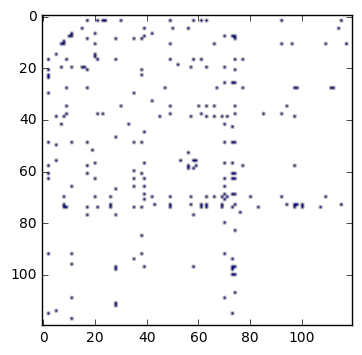

In [83]:
B = A.replace(0, np.nan)
fig, ax = plt.subplots()
ax.imshow(B)
plt.show()

And we notice that there are no results after row ~75. We suppose Facebook detected a bot-like behavior and doesn't show any more information. A quick check to a page we know show show a friend list but now doesn't confirms this.

### Re-scraping

We launch the stalker again with an another account:

In [96]:
cred = pd.read_table('castafiore.txt', header=None)[0].tolist()
df2 = s.df
adj2 = s.adj

We limit ourselves to the missing rows

In [97]:
tail = df[75:]

In [98]:
s2 = Stalker(df2, adj2, cred)

In [99]:
s2.connect()

connecting
plugged in


In [100]:
for rows in tail.iterrows():
    o = rows[1]
    current = s2.collectFriends(o.prenom_nom_court, '', '')
    s.updateDf(current)

 
 
Searching for hugo michel
found hugo michel
searching for their friends
found'em
scrolling
done scrolling
making soup
eating soup
friends friended
 
data saved at: stalker_data/1476358619_819946/1476362423_20566_hugo_michel/
 
 
Searching for matthias minder
found matthias minder
searching for their friends
found'em
scrolling
done scrolling
making soup
eating soup
friends friended
 
info added
adj updated
 
data saved at: stalker_data/1476358619_819946/1476362477_394142_matthias_minder/
 
 
Searching for camille mitchell
found camille mitchell
searching for their friends
oh, the empty set
no friends this time
 
data saved at: stalker_data/1476358619_819946/1476362480_327776_camille_mitchell/
 
 
Searching for marina morisod
oh, the empty set
my man, marina morisod does not exist here
oh, the empty set
no friends this time
 
data saved at: stalker_data/1476358619_819946/1476362481_777331_marina_morisod/
 
 
Searching for clara nguyen
found clara nguyen
searching for their friends
oh

We take a look at the new adjacency matrix:

In [101]:
C = s2.adj

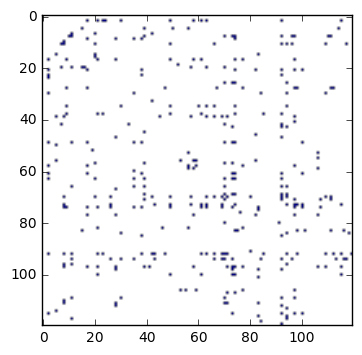

In [227]:
C = C.replace(0, np.nan)
fig, ax = plt.subplots()
ax.imshow(C)
plt.show()

And we now see that we have a more complete matrix. Although it remains to be shown if the empty bottom right corner is due to people not showing their friends publicly or to Facebook blocking us.

## Building the graph

We would like to turn our adjacency matrix into a graph, so we prepare the data for importing into gephi. As an example, we will color the vertices of the graph according to gender, so we need to find the gender associated with each sciper #.

We load this information:

In [171]:
adja = C.fillna(0)
info = s2.df
info = info.replace('Madame', 1)
info = info.replace('Monsieur', 0)
info = info.set_index('sciper')
info.head(2)

,civilite,prenom_nom,prenom_nom_court,fb_name,fb_id,fb_username
sciper,,,,,,
245062,0,Jérémy Constant Henry Alexandre,jeremy alexandre,,,
249684,0,Arthur Léo Maurin Babey,arthur babey,,,


We assume that rows with no information are the result of the information gathering process, and do not mean that person has no friends in the class. This is of course up for debate and wrong in some cases. 

How we will get a clearer graph if we only consider rows that bear information.

We thus fill an array with Sciper # of such rows, and at the same time we calculate the proportion of rows with information in our matrix.

First, some functions we'll need:

In [267]:
def stripNulls(adja):
    """ Takes an adj. matrix and returns indices of non-zero rows
        prints non-zero rows proportion to total
    
    Args:
        adja (df): DataFrame of an adj. matrix, indexed by sciper
        
    Returns:
        array: indices of non-zero rows with their # of friends [[idx, #friends]]
    """
    sums = adja.sum(axis=0)
    prop = {'empty': 0, 'nonempty': 0}
    rows = sums.index
    nodes = []
    
    # looping through row sums
    for idx, val in enumerate(sums):
        if val > 0:
            nodes.append([rows[idx], val])
            prop['nonempty'] += 1
        else:
            prop['empty'] += 1
    
    print('Info on '+str(round((prop['nonempty']/(prop['nonempty']+prop['empty']))*100, 2))+'% of rows')
    
    return nodes

def getAvDegree(nodes):
    """ Takes a nodes array and calculates average degree 
    
    Args:
        nodes (array of arrays): [[idx, #friends]]
        
    Returns:
        float: average degree
    """
    degrees = [x[1] for x in nodes]
    return sum(degrees)/len(nodes)

In [276]:
nodes = stripNulls(adja)

Info on 63.33% of rows


### Vertices

In order to conditionally style vertices on gephi, we need to pass it a list of nodes with IDs, labels and attributes. We will use Scipher # as ID and label and give it a gender attribute.

In [278]:
labels = {'Id': [], 'Label': [], 'Gender': []}

In [279]:
for node in nodes:
    labels['Id'].append(node[0])
    labels['Label'].append(node[0])
    labels['Gender'].append(info.loc[node[0], 'civilite'])

We then save this information as a csv file

In [280]:
gephiLabels = pd.DataFrame(labels)
gephiLabels.head(2)

,Gender,Id,Label
0,1,259150,259150
1,0,198199,198199


In [281]:
gephiLabels.to_csv('gephi/labels.csv', sep=',', encoding='utf-8', index=False)

### Edges

We now move to exporting an edges csv file. Gephi needs to be passed a list of edges with vertices IDs as sources and targets. 

We initialize an empty dict that will be filled with this info and we go through the adjacency matrix to fill the graph dict. As the matrix is symmetric, it is enough to loop over its upper triangular part.

In [282]:
def getEdges(adja, nodes):
    """ Takes nodes and adj. matrix and returns an edge dict """
    graph = {'source': [], 'target': []}
    
    # outer loop
    for idx, node in enumerate(nodes):
        source = node[0]
        # inner loop starting from the diagonal
        for target in nodes[idx:]:
            # getting the value of the cell
            val = adja.loc[adja.index == source, target[0]].values.tolist()[0]
            # if 1
            if val == 1:
                graph['source'].append(source)
                graph['target'].append(target[0])
                
    return graph

In [283]:
graph = getEdges(adja, nodes)

We save it to a file

In [288]:
gephiEdges = pd.DataFrame({'Source': graph['source'], 'Target': graph['target']})
gephiEdges.to_csv('gephi/edges.csv', sep=',', encoding='utf-8', index=False)

## Taking a look at the graph

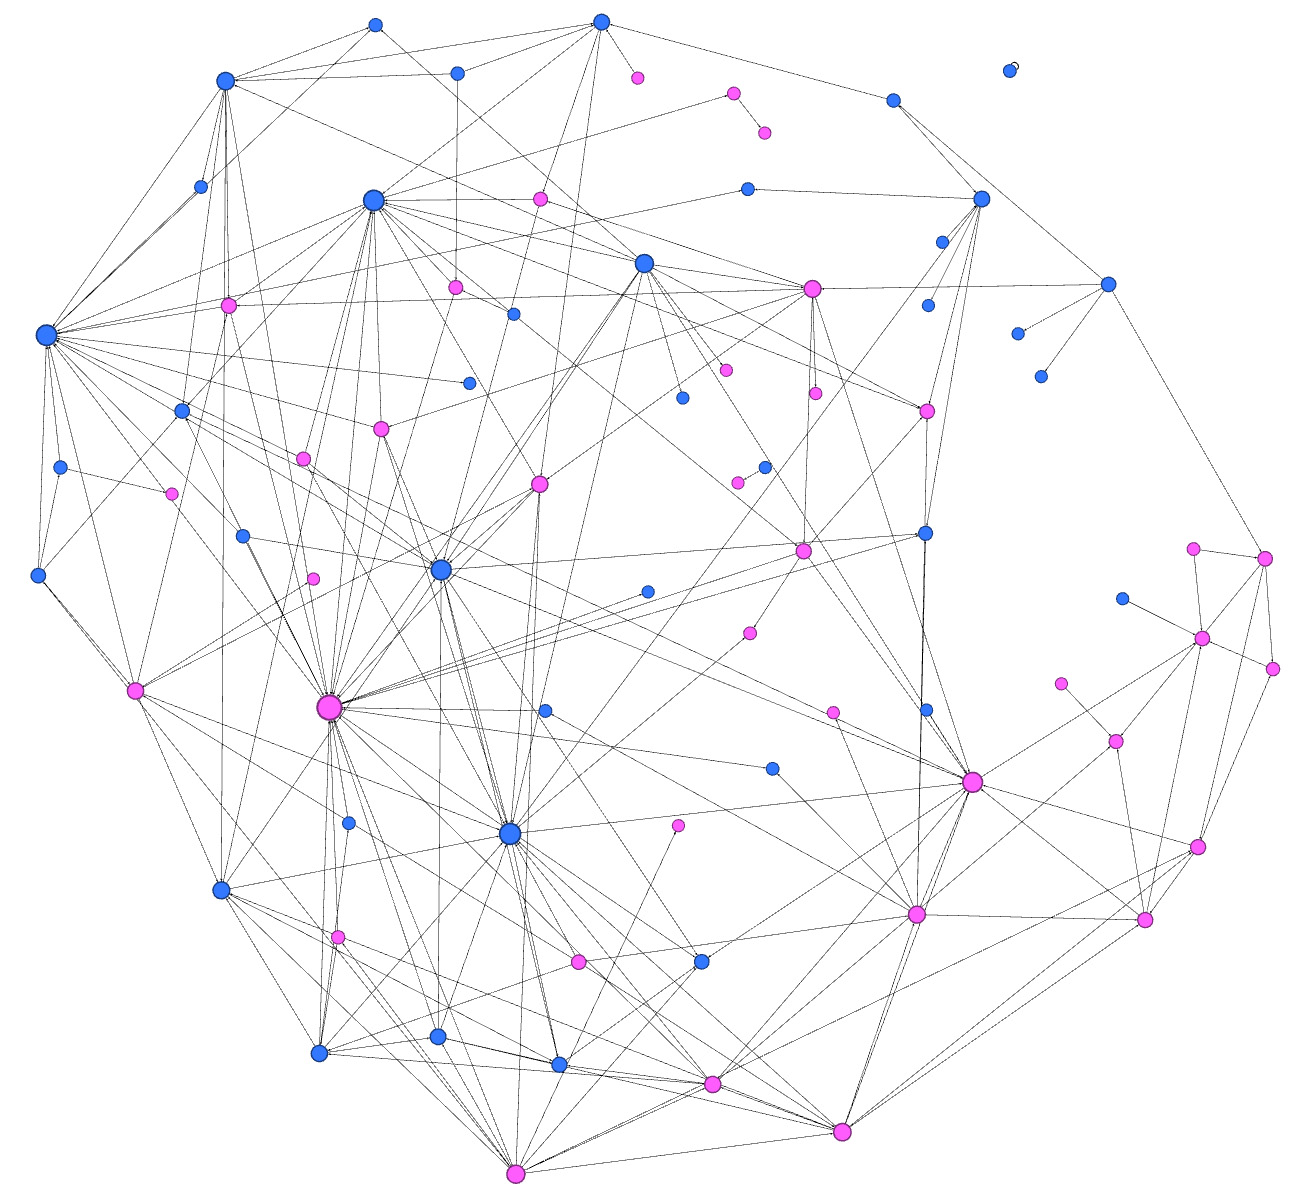

In [315]:
Image(filename='graph.jpg')

### Is the average degree the same for men and women?

We separate our nodes list between men and women

In [309]:
women = []
men = []

In [310]:
for node in nodes:
    if info.loc[node[0], 'civilite'] == 1:
        women.append(node)
    else:
        men.append(node)

We compute their respective average degree

In [314]:
print(' ')
print('Av. degree women: '+str(getAvDegree(women)))
print(' ')
print('Av. degree men: '+str(getAvDegree(men)))

 
Av. degree women: 5.05405405405
 
Av. degree men: 4.76923076923


Is this difference significative? We can use the t-test to figure it out, as we're considering the means of two samples.

In [318]:
womenDegrees = [x[1] for x in women]
menDegrees = [x[1] for x in men]

In [320]:
stats.ttest_ind(a=womenDegrees, b=menDegrees)

Ttest_indResult(statistic=0.28029264779596474, pvalue=0.78003507791427784)

The p-value being way above 0.05, this difference is not significative!

## What next?

Collecting more data like this could allow us to observe interesting things such as connectivity between departments, between school years, clustering etc.